# Análisis del método

**Nota:** Por favor leer el archivo vaepReadMe.md para obtener más información incluyendo el orden en que se deben ejecutar los scripts

El estudio original realizado por el grupo "friends of tracking" se centra en la explicación del algoritmo y la evaluación de jugadores utilizando el método, sin embargo, nunca prueba la validez de este. 

El objetivo de este script es verificar que un incremento del valor VAEP acumulado de un equipo se traduce en un mayor porcentaje de victorias, validando así el método.

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("Vaep-data-analysis")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
from pyspark.sql.functions import when

### Porcentaje de victorias y goles por equipo

Un método de estimación tradicional del porcentaje de victorias es la utilización del índice "Pythagorean expectation". Este índice se calcula como el cuadrado de los goles a favor sobre el cuadrado de los goles a favor menos el cuadrado de los goles en contra, el valor obtenido tiene una fuerte correlación con el porcentaje de victorias del equipo.

En esta sección de calcula el valor índice, el porcentaje de victorias de cada equipo y se muestra su alta correlación lineal.

In [5]:
parquetData = '/dataset/vaep/parquet/matches.parquet'

In [6]:
df_parquet = spark.read.parquet(parquetData)

In [7]:
df_parquet.createOrReplaceTempView("matches")

In [8]:
query='''

Select competitionid, team_id, sum(goalsFavor) as goalsFavorTotal,
sum(goalsAgainst) as goalsAgainstTotal, sum(goalsFavor)-sum(goalsAgainst) goalDiffTotal ,sum(points) as pointsTotal, 
sum(count) as npartidos, sum(winflag) as wins, sum(drawflag) as draws, sum(loseflag) as lose
from
(
SELECT competitionid,team1_teamId as team_id, team1_score as goalsFavor,  team2_score as goalsAgainst,
case when winner=team1_teamId then 3 else (case when winner=0 then 1 else 0 END ) END as points,
case when winner=team1_teamId then 1 else 0 END as winflag,
case when winner=0 then 1 else 0 END as drawflag,
case when winner=team2_teamId then 1 else 0 END loseflag,
1 as count
FROM matches

UNION ALL

SELECT competitionid, team2_teamId as team_id, team2_score as goalsFavor,  team1_score as goalsAgainst,
case when winner=team2_teamId then 3 else (case when winner=0 then 1 else 0 END ) END as points,
case when winner=team2_teamId then 1 else 0 END as winflag,
case when winner=0 then 1 else 0 END as drawflag,
case when winner=team1_teamId then 1 else 0 END loseflag,
1 as count
FROM matches
)
group by competitionid,team_id
Order by competitionid, pointsTotal desc

'''


In [9]:
matchResults = spark.sql(query)
matchResults.show(5)

+-------------+-------+---------------+-----------------+-------------+-----------+---------+----+-----+----+
|competitionid|team_id|goalsFavorTotal|goalsAgainstTotal|goalDiffTotal|pointsTotal|npartidos|wins|draws|lose|
+-------------+-------+---------------+-----------------+-------------+-----------+---------+----+-----+----+
|          364|   1625|            106|               27|           79|        100|       38|  32|    4|   2|
|          364|   1611|             68|               28|           40|         81|       38|  25|    6|   7|
|          364|   1624|             74|               36|           38|         77|       38|  23|    8|   7|
|          364|   1612|             84|               38|           46|         75|       38|  21|   12|   5|
|          364|   1610|             62|               38|           24|         70|       38|  21|    7|  10|
+-------------+-------+---------------+-----------------+-------------+-----------+---------+----+-----+----+
only showi

In [10]:
# Aquí se crean dos variables adicionales wpc que es el porcentaje de victorias (para este ejercicio 
# una victoria se le asigna el valor 1 y un empate 0, se podría usar 3 y 1 también) y luego se crea el índice 
# con el nombre pyth.


matchResults=matchResults.withColumn("wpc",(matchResults['wins']+matchResults['draws']*0.5)/matchResults['npartidos'])
matchResults=matchResults.withColumn("pyth",matchResults['goalsFavorTotal']**2/(matchResults['goalsFavorTotal']**2 + matchResults['goalsAgainstTotal']**2))
matchResults.show(5)

+-------------+-------+---------------+-----------------+-------------+-----------+---------+----+-----+----+------------------+------------------+
|competitionid|team_id|goalsFavorTotal|goalsAgainstTotal|goalDiffTotal|pointsTotal|npartidos|wins|draws|lose|               wpc|              pyth|
+-------------+-------+---------------+-----------------+-------------+-----------+---------+----+-----+----+------------------+------------------+
|          364|   1625|            106|               27|           79|        100|       38|  32|    4|   2|0.8947368421052632|0.9390722941913916|
|          364|   1611|             68|               28|           40|         81|       38|  25|    6|   7|0.7368421052631579|0.8550295857988166|
|          364|   1624|             74|               36|           38|         77|       38|  23|    8|   7|0.7105263157894737|0.8086237448316598|
|          364|   1612|             84|               38|           46|         75|       38|  21|   12|   5|0.7

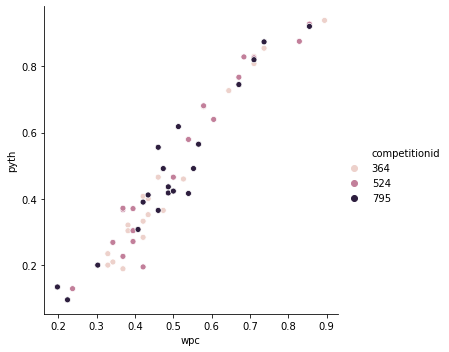

In [11]:
# En el siguiente grafico puede apreciarse que el porcentaje de victorias es proporcional al índice 
# para las 3 ligas analizadas.

g=sns.relplot(x="wpc", y="pyth", data=matchResults.toPandas() ,hue='competitionid', legend="full")

### Relación del porcentaje de victoria con el índice VAEP

En esta seccion se realiza un analisis similar al realizado en la seccion anterior pero utilizando el índice VAEP acumulado por los equipos a lo largo de la temporada tanto a favor o en contra en lugar de de los goles.

Como el índice VAEP en el fondo se basa en la probabilidad de anotar un gol, este muestra una correlacion muy fuerte con la cantidad de goles anotados. Debido a esto se puede calcular un índice "Pythagorean" utilizando el valor VAEP acumulado en lugar de los goles probando de esta manera que el índice esta relacionado con el porcentaje de victorias.

In [12]:
parquetData = '/dataset/vaep/parquet/match_events.parquet'

In [13]:
df_parquet = spark.read.parquet(parquetData)

In [14]:
df_parquet.createOrReplaceTempView("eventsAnalysis")

In [15]:
# Esta query obtiene el VAEP ofensivo, el VAEP defensivo y el VAEP total tanto a favor como en contra por equipo 

query='''

select team_id, short_team_name, sum(offensiveVAEP) as offensiveVAEP, sum(defensiveVAEP) as defensiveVAEP, sum(totalVAEP) as totalVAEP,
sum(offensiveVAEP2) as offensiveVAEPAgainst, sum(defensiveVAEP2) as defensiveVAEPAgainst, sum(totalVAEP2) as totalVAEPAgainst
from
(
SELECT game_id, team_id, short_team_name, sum(offensive_value) as offensiveVAEP, sum(defensive_value) as defensiveVAEP, sum(vaep_value) as totalVAEP
FROM eventsAnalysis
group by game_id, team_id, short_team_name
) as team1data

join

(
SELECT game_id, team_id as team_id2, short_team_name as short_team_name2, sum(offensive_value) as offensiveVAEP2, sum(defensive_value) as defensiveVAEP2, sum(vaep_value) as totalVAEP2
FROM eventsAnalysis
group by game_id, team_id, short_team_name
) as team2data

on team1data.game_id=team2data.game_id
where team_id<>team_id2
group by team_id, short_team_name
order by totalVAEP desc

'''

In [16]:
vaepPerTeam = spark.sql(query)
vaepPerTeam.show(5)

+-------+---------------+------------------+------------------+------------------+--------------------+--------------------+-----------------+
|team_id|short_team_name|     offensiveVAEP|     defensiveVAEP|         totalVAEP|offensiveVAEPAgainst|defensiveVAEPAgainst| totalVAEPAgainst|
+-------+---------------+------------------+------------------+------------------+--------------------+--------------------+-----------------+
|    676|      Barcelona|131.61614200664917|2.7090651254402474|134.32520689000376|    57.1857343907468|  12.108149793290067|69.29388393694535|
|   1625|Manchester City|128.02869891596492| 2.398949943657499|130.42764845152533|  48.648428832457284|  7.4138100178097375|56.06223871058319|
|    675|    Real Madrid|120.54590294212903| 7.809658260841388|128.35556118335808|   75.44652859208873|  11.048859301256016|86.49538784299148|
|   1612|      Liverpool|112.77565603918629|3.9046886678552255|116.68034454190638|   61.02568000170868|     9.8377169315645|70.86339705443243|

In [17]:
# Aquí se juntan las tablas de partidos goles y victorias con los índices VAEP

fullmatchData=pd.merge(matchResults.toPandas(), vaepPerTeam.toPandas(), on = ['team_id'])
fullmatchData.head()

,competitionid,team_id,goalsFavorTotal,goalsAgainstTotal,goalDiffTotal,pointsTotal,npartidos,wins,draws,lose,wpc,pyth,short_team_name,offensiveVAEP,defensiveVAEP,totalVAEP,offensiveVAEPAgainst,defensiveVAEPAgainst,totalVAEPAgainst
0,364,1625,106,27,79,100,38,32,4,2,0.894737,0.939072,Manchester City,128.028699,2.398950,130.427648,48.648429,7.413810,56.062239
1,364,1611,68,28,40,81,38,25,6,7,0.736842,0.855030,Manchester United,98.588145,7.553935,106.142079,61.822269,8.384479,70.206747
2,364,1624,74,36,38,77,38,23,8,7,0.710526,0.808624,Tottenham Hotspur,97.944202,2.274331,100.218533,61.034537,5.925000,66.959536
3,364,1612,84,38,46,75,38,21,12,5,0.710526,0.830118,Liverpool,112.775656,3.904689,116.680345,61.025680,9.837717,70.863397
4,364,1610,62,38,24,70,38,21,7,10,0.644737,0.726929,Chelsea,92.046647,5.915663,97.962310,66.009175,9.934507,75.943682


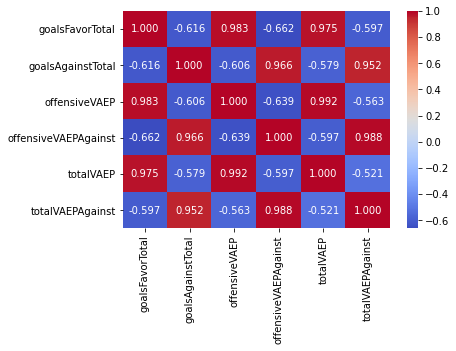

In [18]:
# Aquí puede verse la alta correlación entre el VAEP total y el VAEP ofensivo con los goles a favor, y entre el VAEP total y
# ofensivo en contra con los goles en contra.

g = sns.heatmap(fullmatchData[['goalsFavorTotal','goalsAgainstTotal','offensiveVAEP','offensiveVAEPAgainst','totalVAEP','totalVAEPAgainst']].corr(),
                annot=True, fmt = ".3f", cmap = "coolwarm")

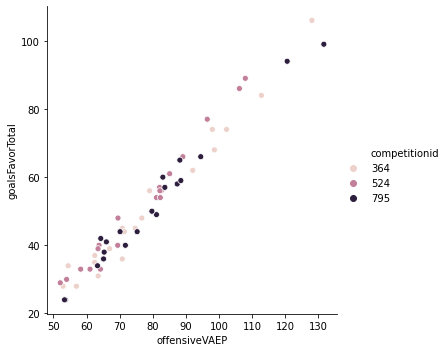

In [19]:
# Grafico de los goles a favor y el VAEP ofensivo

g=sns.relplot(x="offensiveVAEP", y="goalsFavorTotal", data =fullmatchData ,hue='competitionid', legend="full")

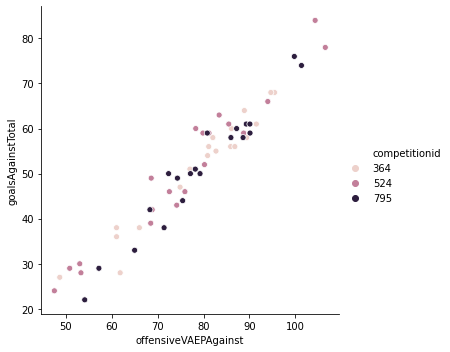

In [20]:
# Grafico de los goles en contra  y el VAEP ofensivo en contra

g=sns.relplot(x="offensiveVAEPAgainst", y="goalsAgainstTotal", data =fullmatchData ,hue='competitionid', legend="full")

In [21]:
# Se calcula un nuevo índice "Pythagorean" utilizando el VAEP total a favor y en contra (se podría utilizar el ofensivo pero
# el total da mejor resultado)

fullmatchData['pythVaep'] = fullmatchData['totalVAEP']**2/(fullmatchData['totalVAEP']**2 + fullmatchData['totalVAEPAgainst']**2)

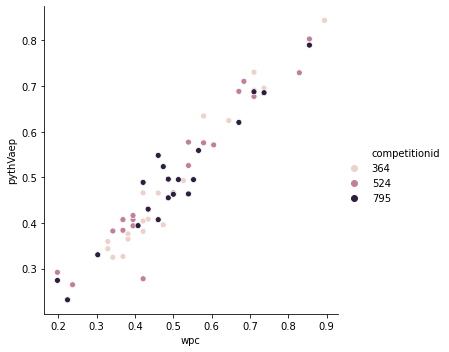

In [22]:
# Se muestra que el nuevo índice también guarda una relación bastante lineal con el porcentaje de victorias.

g=sns.relplot(x="wpc", y="pythVaep", data =fullmatchData ,hue='competitionid', legend="full")

### Análisis de victorias y derrotas 

En esta sección se analiza la relación entre la diferencia del VAEP a favor y en contra con la diferencia de goles por partido. Se prueba que mientras mayor sea la diferencia de VAEP, mayor será la diferencia de gol a favor, con lo cual, la probabilidad de ganar aumenta.

In [23]:
# Esta query calcula la diferencia de vaep total a favor y en contra por partido por equipo

query='''

select team1data.game_id ,team_id,short_team_name, team_id2,short_team_name2, sum(totalVAEP) - sum(totalVAEP2) as totalVAEPDiff
from
(
SELECT game_id, team_id, short_team_name, sum(offensive_value) as offensiveVAEP, sum(defensive_value) as defensiveVAEP, sum(vaep_value) as totalVAEP
FROM eventsAnalysis
group by game_id, team_id, short_team_name
) as team1data

join

(
SELECT game_id, team_id as team_id2, short_team_name as short_team_name2, sum(offensive_value) as offensiveVAEP2, sum(defensive_value) as defensiveVAEP2, sum(vaep_value) as totalVAEP2
FROM eventsAnalysis
group by game_id, team_id, short_team_name
) as team2data

on team1data.game_id=team2data.game_id
where team_id<>team_id2
group by team1data.game_id ,team_id,short_team_name, team_id2,short_team_name2
order by totalVAEPDiff desc




'''

In [24]:
vaepdifPerGame = spark.sql(query)
vaepdifPerGame.show(5)

+-------+-------+---------------+--------+-------------------+-----------------+
|game_id|team_id|short_team_name|team_id2|   short_team_name2|    totalVAEPDiff|
+-------+-------+---------------+--------+-------------------+-----------------+
|2576186|   3159|       Juventus|    3315|           Sassuolo|6.810431888559833|
|2565738|    675|    Real Madrid|     677|Deportivo La Coruña|6.391430085001048|
|2499794|   1625|Manchester City|    1639|         Stoke City|6.107440480380319|
|2565595|    674|       Valencia|     683|             Málaga|5.254037733713631|
|2500080|   1609|        Arsenal|    1646|            Burnley|5.253435037680902|
+-------+-------+---------------+--------+-------------------+-----------------+
only showing top 5 rows



In [25]:
# Notar que la cantidad de partidos se duplica porque se hace desde el punto de vista de ambos equipos
vaepdifPerGame.count()

2280

In [26]:
vaepdifPerGame.createOrReplaceTempView("vaepdifPerGame")

In [27]:
# Esta query agrega a cada partido la diferencia de goles y si se ganó o no el partido

query='''

SELECT vaepdifPerGame.game_id, vaepdifPerGame.team_id, vaepdifPerGame.short_team_name, vaepdifPerGame.team_id2, vaepdifPerGame.short_team_name2, vaepdifPerGame.totalVAEPDiff,
case when winner=vaepdifPerGame.team_Id then 'Win' else (case when winner=0 then 'Draw' else 'Lose' END ) END as result,
case when winner=vaepdifPerGame.team_Id then 1 else 0 END as winflag,
case when matches.team1_teamId=vaepdifPerGame.team_id then (matches.team1_score-matches.team2_score) else (matches.team2_score-matches.team1_score) END as goaldiff


FROM matches join vaepdifPerGame on matches.wyId=vaepdifPerGame.game_id

'''

In [28]:
fullVaepPerMatch = spark.sql(query)
fullVaepPerMatch.show(5)

+-------+-------+---------------+--------+-------------------+-----------------+------+-------+--------+
|game_id|team_id|short_team_name|team_id2|   short_team_name2|    totalVAEPDiff|result|winflag|goaldiff|
+-------+-------+---------------+--------+-------------------+-----------------+------+-------+--------+
|2576186|   3159|       Juventus|    3315|           Sassuolo|6.810431888559833|   Win|      1|       7|
|2565738|    675|    Real Madrid|     677|Deportivo La Coruña|6.391430085001048|   Win|      1|       6|
|2499794|   1625|Manchester City|    1639|         Stoke City|6.107440480380319|   Win|      1|       5|
|2565595|    674|       Valencia|     683|             Málaga|5.254037733713631|   Win|      1|       5|
|2500080|   1609|        Arsenal|    1646|            Burnley|5.253435037680902|   Win|      1|       5|
+-------+-------+---------------+--------+-------------------+-----------------+------+-------+--------+
only showing top 5 rows



In [29]:
# hay que corregir un par de valores que vienen mal del dataset
fullVaepPerMatch.where((fullVaepPerMatch.result == 'Draw') & (fullVaepPerMatch.goaldiff!=0)).show()

+-------+-------+--------------------+--------+--------------------+-------------------+------+-------+--------+
|game_id|team_id|     short_team_name|team_id2|    short_team_name2|      totalVAEPDiff|result|winflag|goaldiff|
+-------+-------+--------------------+--------+--------------------+-------------------+------+-------+--------+
|2499997|   1644|             Watford|    1623|             Everton| 1.3710207622498274|  Draw|      0|       1|
|2565862|    698|              Getafe|     691|            Espanyol| 0.8400223162025213|  Draw|      0|       1|
|2500012|   1623|             Everton|    1651|Brighton & Hove A...| 0.2783736549317837|  Draw|      0|       2|
|2500012|   1651|Brighton & Hove A...|    1623|             Everton|-0.2783736549317837|  Draw|      0|      -2|
|2565862|    691|            Espanyol|     698|              Getafe|-0.8400223162025213|  Draw|      0|      -1|
|2499997|   1623|             Everton|    1644|             Watford|-1.3710207622498274|  Draw| 

In [30]:
fullVaepPerMatch.where((fullVaepPerMatch.result == 'Draw') & (fullVaepPerMatch.goaldiff>0)).show()

+-------+-------+---------------+--------+--------------------+------------------+------+-------+--------+
|game_id|team_id|short_team_name|team_id2|    short_team_name2|     totalVAEPDiff|result|winflag|goaldiff|
+-------+-------+---------------+--------+--------------------+------------------+------+-------+--------+
|2499997|   1644|        Watford|    1623|             Everton|1.3710207622498274|  Draw|      0|       1|
|2565862|    698|         Getafe|     691|            Espanyol|0.8400223162025213|  Draw|      0|       1|
|2500012|   1623|        Everton|    1651|Brighton & Hove A...|0.2783736549317837|  Draw|      0|       2|
+-------+-------+---------------+--------+--------------------+------------------+------+-------+--------+



In [31]:
#se corrigen los valores errados

fullVaepPerMatch = fullVaepPerMatch.withColumn("result", when(fullVaepPerMatch.goaldiff >0,"Win") \
      .when(fullVaepPerMatch.goaldiff < 0,"Lose") \
      .otherwise(fullVaepPerMatch.result))

fullVaepPerMatch = fullVaepPerMatch.withColumn("winflag", when(fullVaepPerMatch.goaldiff >0, 1) \
      .when(fullVaepPerMatch.goaldiff < 0, 0) \
      .otherwise(fullVaepPerMatch.winflag))


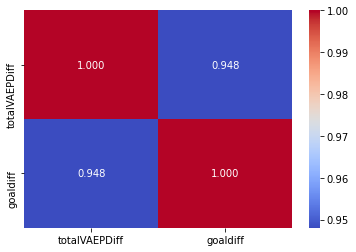

In [32]:
# Se muestra la alta correlación entre la diferencia de goles y la diferencia de VAEP por partido

g = sns.heatmap(fullVaepPerMatch.select('totalVAEPDiff', 'goaldiff').toPandas().corr(),
                annot=True, fmt = ".3f", cmap = "coolwarm")

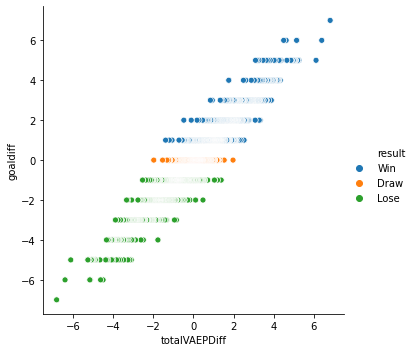

In [33]:
g=sns.relplot(x="totalVAEPDiff", y="goaldiff", data =fullVaepPerMatch.toPandas() ,hue='result')

# En este gráfico puede observarse que a mayor diferencia de VAEP hay mayor diferencia de gol. Para valores de VAEP muy 
# altos el equipo gana los partidos, pero para los valores cercanos a cero pueden darse tanto empates victorias y derrotas.

### Análisis de probabilidad de victoria 

En esta sección se utilizan una regresión logística para mostrar como varia la probabilidad de victoria en base al valor de la diferencia de VAEP.

**Nota:** De la misma manera que se puede usar una regresión con todos los puntos para mostrar como una recta ajusta los datos, en este ejercicio se usa una regresión logística con todos los datos para mostrar como ajusta la curva a todos los datos (no hay train y test) y utilizando esa curva se analizan las probabilidades de victoria. Para ver cómo funciona el índice como predictor mirar el script de predicción.


In [34]:
df=fullVaepPerMatch.select('winflag','result','totalVAEPDiff')
df.show()

+-------+------+------------------+
|winflag|result|     totalVAEPDiff|
+-------+------+------------------+
|      1|   Win| 6.810431888559833|
|      1|   Win| 6.391430085001048|
|      1|   Win| 6.107440480380319|
|      1|   Win| 5.254037733713631|
|      1|   Win| 5.253435037680902|
|      1|   Win| 5.197848386596888|
|      1|   Win| 5.196365279320162|
|      1|   Win| 5.156921313144267|
|      1|   Win| 5.138717727269977|
|      1|   Win| 5.084834983048495|
|      1|   Win|5.0703606777242385|
|      1|   Win| 5.058232673909515|
|      1|   Win| 5.025967113557272|
|      1|   Win| 4.988158743595704|
|      1|   Win| 4.967536365264095|
|      1|   Win| 4.889950550626963|
|      1|   Win| 4.863394259416964|
|      1|   Win| 4.857641160022467|
|      1|   Win| 4.654069984040689|
|      1|   Win| 4.619656831491739|
+-------+------+------------------+
only showing top 20 rows



In [35]:
feature_cols=['totalVAEPDiff']

In [36]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)
df.select('features').show()

+--------------------+
|            features|
+--------------------+
| [6.810431888559833]|
| [6.391430085001048]|
| [6.107440480380319]|
| [5.254037733713631]|
| [5.253435037680902]|
| [5.197848386596888]|
| [5.196365279320162]|
| [5.156921313144267]|
| [5.138717727269977]|
| [5.084834983048495]|
|[5.0703606777242385]|
| [5.058232673909515]|
| [5.025967113557272]|
| [4.988158743595704]|
| [4.967536365264095]|
| [4.889950550626963]|
| [4.863394259416964]|
| [4.857641160022467]|
| [4.654069984040689]|
| [4.619656831491739]|
+--------------------+
only showing top 20 rows



In [37]:
#Se utilizan todos los datos para generar la curva

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='winflag', featuresCol='features')
lrm = lr.fit(df)


In [38]:
# Pude observarse que la curva ajusta bastante bien los datos
lrm.summary.accuracy

0.918859649122807

In [39]:
# El indice ROC tambien da bien
lrm.summary.areaUnderROC

0.9694276480400332

In [40]:
pred_df = lrm.transform(df)

In [41]:
# Reviso que de el mismo valor para estar seguro que los datos están bien

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='winflag')
evaluator.evaluate(pred_df)

0.9694105439428716

In [42]:
pred_df.show()

+-------+------+--------------------+--------------------+--------------------+--------------------+----------+
|winflag|result|       totalVAEPDiff|            features|       rawPrediction|         probability|prediction|
+-------+------+--------------------+--------------------+--------------------+--------------------+----------+
|      0|  Lose|   -1.24479228281416| [-1.24479228281416]|[5.96621656998565...|[0.99744263337556...|       0.0|
|      1|   Win|    1.24479228281416|  [1.24479228281416]|[-2.5567306988872...|[0.07197561028413...|       1.0|
|      0|  Lose| -0.7239726117695682|[-0.7239726117695...|[4.18322086291494...|[0.98497973625579...|       0.0|
|      1|   Win|  0.7239726117695682|[0.7239726117695682]|[-0.7737349918165...|[0.31567170689902...|       1.0|
|      0|  Lose| -1.7041606863494962|[-1.7041606863494...|[7.53883745395627...|[0.99946826713502...|       0.0|
|      1|   Win|  1.7041606863494962|[1.7041606863494962]|[-4.1293515828578...|[0.01583841803743...|    

In [43]:
# Se obtiene la probabilidad de ganar y se la agrega a un dataframe de pandas con el resultado y la diferencia de VAEP

probWin=pred_df.select("result","probability","totalVAEPDiff").toPandas()
probWin['winProb']=probWin['probability'].str[1]
probWin.head()

,result,probability,totalVAEPDiff,winProb
0,Win,"[4.11845583950816e-10, 0.9999999995881543]",6.810432,1.0
1,Win,"[1.7286165223894493e-09, 0.9999999982713834]",6.391430,1.0
2,Win,"[4.570137092149111e-09, 0.9999999954298628]",6.107440,1.0
3,Win,"[8.486973509855759e-08, 0.9999999151302649]",5.254038,1.0
4,Win,"[8.504502713110692e-08, 0.9999999149549729]",5.253435,1.0


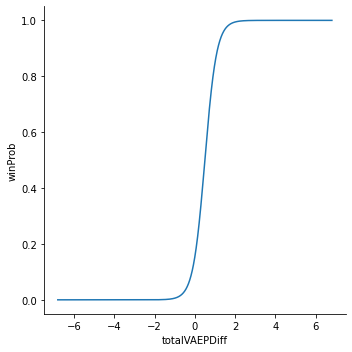

In [44]:
# Puede verse que la curva de probabilidades tiene una pendiente muy empinada lo que implica que, cerca del cero, pequeños
# dambios de la diferencia de vaep hace cambiar mucho la probabilidad de ganar.

g=sns.relplot(x="totalVAEPDiff", y='winProb', data =probWin, kind="line")

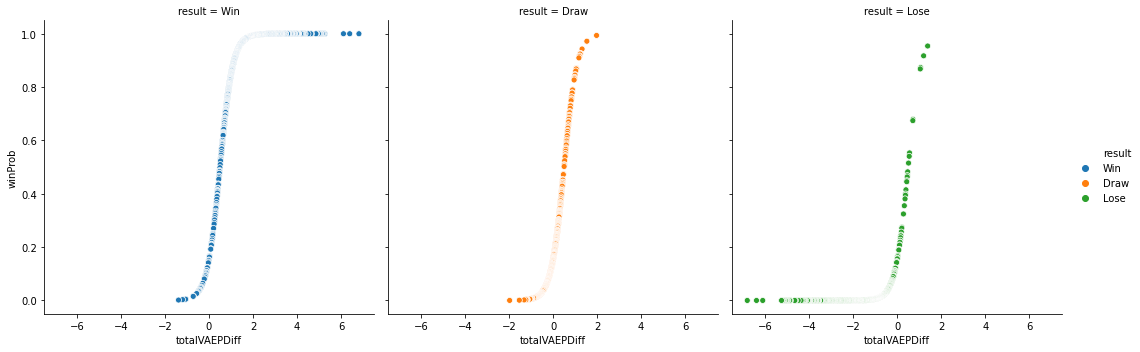

In [45]:
# En este gráfico, al igual que el que se realizó en la sección anterior puede verse como cerca del cero hay tanto empates 
# victorias y derrotas y al alejarse del cero quedan solo derrotas o victorias dependiendo del sentido.

g=sns.relplot(x="totalVAEPDiff", y='winProb', data =probWin, hue='result', col="result")

In [46]:
# Se calcula la diferencia de VAEP que tiene que haber para tener 75% de probabilidad de ganar

thr=0.75
probWin[probWin.winProb>thr]['totalVAEPDiff'].min()

0.8189646690152586

In [47]:
# Se calculan cuantos partidos hubo donde la probabilidad de ganar fue mayor que 75%

probWin[probWin.winProb>thr]['totalVAEPDiff'].count()

713

### Conclusión:

Se ha demostrado que el índice VAEP es válido para la evaluación del desempeño a largo plazo de un equipo dada su relación casi lineal con el porcentaje de victorias.

La principal ventaja del índice es que al ser generado por las acciones de los jugadores este permite mostrar cuando contribuye cada jugador a la victoria (un análisis de los goles a favor o en contra no tiene esta ventaja). Para más ver graficas en superset. 

En cuanto a la evaluación de partidos individuales, la diferencia entre el índice vaep generado por un equipo y otro durante el partido tiene una alta correlación con la diferencia de goles. Para diferencias altas de VAEP es prácticamente seguro que el equipo ganará o perderá (dependiendo de si la diferencia es a favor o en contra). Para diferencias bajas cualquiera de los tres resultados puede darse y el índice no es un estimador lo suficientemente fuerte por sí solo para decir quien ganara.  

In [48]:
spark.stop()